In [6]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.datasets as datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
from torch.optim import Adam
import torch.nn as nn
import numpy as np
from sklearn.metrics import roc_auc_score
from torch.utils.data import Dataset
import torch.nn.functional as F
import joblib
import os

/home/raj/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
''' ApplyTransform is adapted from https://stackoverflow.com/questions/56582246/correct-data-loading-splitting-and-augmentation-in-pytorch
'''

class ApplyTransform(Dataset):
    """
    Apply transformations to a Dataset

    Arguments:
        dataset (Dataset): A Dataset that returns (sample, target)
        transform (callable, optional): A transform to be applied on the sample
        target_transform (callable, optional): A transform to be applied on the target

    """
    def __init__(self, dataset, transform=None, target_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample, target = self.dataset[idx]
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target

    def __len__(self):
        return len(self.dataset)
        
        

    
    
    
    
    
    
## This function is related to OOD using Evidential Deep Learning
## This is adopted from https://github.com/dougbrion/pytorch-classification-uncertainty/blob/master/losses.py
def edl_loss(func, y, alpha, epoch_num, num_classes, annealing_step, device=None):
    y = y.to(device)
    alpha = alpha.to(device)
    S = torch.sum(alpha, dim=1, keepdim=True)

    A = torch.sum(y * (func(S) - func(alpha)), dim=1, keepdim=True)

    annealing_coef = torch.min(
        torch.tensor(1.0, dtype=torch.float32),
        torch.tensor(epoch_num / annealing_step, dtype=torch.float32),
    )

    kl_alpha = (alpha - 1) * (1 - y) + 1
    kl_div = annealing_coef * kl_divergence(kl_alpha, num_classes, device=device)
    return A + kl_div
    
## This function is related to OOD using Evidential Deep Learning
## This is adopted from https://github.com/dougbrion/pytorch-classification-uncertainty/blob/master/losses.py    
def edl_log_loss(output, target, epoch_num, num_classes, annealing_step, device=None):
    # if not device:
    #     device = get_device()
    evidence = relu_evidence(output)
    alpha = evidence + 1
    loss = torch.mean(
        edl_loss(
            torch.log, target, alpha, epoch_num, num_classes, annealing_step, device
        )
    )
    return loss
    
## This function is related to OOD using Evidential Deep Learning
## This is adopted from https://github.com/dougbrion/pytorch-classification-uncertainty/blob/master/losses.py      
def edl_digamma_loss(
    output, target, epoch_num, num_classes, annealing_step, device=None
):
    # if not device:
    #     device = get_device()
    evidence = relu_evidence(output)
    alpha = evidence + 1
    loss = torch.mean(
        edl_loss(
            torch.digamma, target, alpha, epoch_num, num_classes, annealing_step, device
        )
    )
    return loss

## This function is related to OOD using Evidential Deep Learning
## This is adopted from https://github.com/dougbrion/pytorch-classification-uncertainty/blob/master/losses.py  
def relu_evidence(y):
    return F.relu(y)    
    
## This function is related to OOD using Evidential Deep Learning
## This is adopted from https://github.com/dougbrion/pytorch-classification-uncertainty/blob/master/losses.py    
def kl_divergence(alpha, num_classes, device=None):
    # if not device:
    #     device = get_device()
    ones = torch.ones([1, num_classes], dtype=torch.float32, device=device)
    sum_alpha = torch.sum(alpha, dim=1, keepdim=True)
    first_term = (
        torch.lgamma(sum_alpha)
        - torch.lgamma(alpha).sum(dim=1, keepdim=True)
        + torch.lgamma(ones).sum(dim=1, keepdim=True)
        - torch.lgamma(ones.sum(dim=1, keepdim=True))
    )
    second_term = (
        (alpha - ones)
        .mul(torch.digamma(alpha) - torch.digamma(sum_alpha))
        .sum(dim=1, keepdim=True)
    )
    kl = first_term + second_term
    return kl
    
def one_hot_embedding(labels, num_classes=10):
    # Convert to One Hot Encoding
    y = torch.eye(num_classes)
    return y[labels]

In [3]:
### Data directory
AID_Directory = '/kaggle/input/aid-scene-classification-datasets/AID'
Optimal31_Directory = '/kaggle/input/optimal-31/OPTIMAL-31/Images'
UCM_Directory = '/kaggle/input/ucmerced/UCMerced_LandUse/Images'

In [4]:
AID_numClasses =  len(list(os.walk(AID_Directory)))-1
Optimal31_numClasses =  len(list(os.walk(Optimal31_Directory)))-1
UCM_numClasses =  len(list(os.walk(UCM_Directory)))-1
print(AID_numClasses, Optimal31_numClasses,UCM_numClasses)

30 31 21


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
#  Load and normalizing dataset
transforms_train = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transforms_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
# Creating Train and Test datasets/dataloaders for AID, optimal-31 and UCMerced images
AID_Dataset = datasets.ImageFolder(AID_Directory, transform=None)
AID_trainSize = int(0.8 * len(AID_Dataset))
AID_testSize = len(AID_Dataset) - AID_trainSize
AID_trainDataset, AID_testDataset = random_split(AID_Dataset, [AID_trainSize, AID_testSize])
AID_trainDataset = ApplyTransform(AID_trainDataset, transform=transforms_train)
AID_testDataset = ApplyTransform(AID_testDataset, transform=transforms_test)
AID_trainDatasetLoader = DataLoader(dataset=AID_trainDataset, batch_size=64)
AID_testDatasetLoader = DataLoader(dataset=AID_testDataset, batch_size=64)

Optimal31_Dataset = datasets.ImageFolder(Optimal31_Directory, transform=None)
Optimal31_trainSize = int(0.8 * len(Optimal31_Dataset))
Optimal31_testSize = len(Optimal31_Dataset) - Optimal31_trainSize
Optimal31_trainDataset, Optimal31_testDataset = random_split(Optimal31_Dataset, [Optimal31_trainSize, Optimal31_testSize])
Optimal31_trainDataset = ApplyTransform(Optimal31_trainDataset, transform=transforms_train)
Optimal31_testDataset = ApplyTransform(Optimal31_testDataset, transform=transforms_test)
Optimal31_trainDatasetLoader = DataLoader(dataset=Optimal31_trainDataset, batch_size=64)
Optimal31_testDatasetLoader = DataLoader(dataset=Optimal31_testDataset, batch_size=64)

UCM_Dataset = datasets.ImageFolder(UCM_Directory, transform=None)
UCM_trainSize = int(0.8 * len(UCM_Dataset))
UCM_testSize = len(UCM_Dataset) - UCM_trainSize
UCM_trainDataset, UCM_testDataset = random_split(UCM_Dataset, [UCM_trainSize, UCM_testSize])
UCM_trainDataset = ApplyTransform(UCM_trainDataset, transform=transforms_train)
UCM_testDataset = ApplyTransform(UCM_testDataset, transform=transforms_test)
UCM_trainDatasetLoader = DataLoader(dataset=UCM_trainDataset, batch_size=64)
UCM_testDatasetLoader = DataLoader(dataset=UCM_testDataset, batch_size=64)

print(AID_trainSize, Optimal31_trainSize, UCM_trainSize)
print(AID_testSize, Optimal31_testSize, UCM_testSize)

8000 1488 1680
2000 372 420


In [8]:
# making group of train and test dataloaders of AID, optimal-31 and UCMerced
all_dataloaders = [[AID_trainDatasetLoader, AID_testDatasetLoader],
                   [Optimal31_trainDatasetLoader, Optimal31_testDatasetLoader],
                   [UCM_trainDatasetLoader, UCM_testDatasetLoader]]
all_numClasses = [AID_numClasses, Optimal31_numClasses,UCM_numClasses]
all_dataset_names = ['AID', 'Optimal-31', 'UCMerced']

In [9]:
# Loading lightweight(mobileNet, shuffleNet) and VIT(heavyweight) models
mobileNet = torchvision.models.mobilenet_v2(weights = 'IMAGENET1K_V1')
shuffleNet = torchvision.models.shufflenet_v2_x1_0(weights='IMAGENET1K_V1')
VIT = torchvision.models.vit_b_16(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth


  0%|          | 0.00/8.79M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [10]:
# function to calculate runtime
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [11]:
# function to calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [12]:
# Train and Test functions for model
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):

    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)
        
        # Optimizer zero grad
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(X)

        # Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # Loss backward
        loss.backward()

        # Optimizer step
        optimizer.step()
        
        # Free up GPU memory
        del X, y, y_pred, loss
        torch.cuda.empty_cache()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss, train_acc

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    


    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y).item()
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
            # Free up GPU memory
            del X, y, test_pred
            torch.cuda.empty_cache()
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        return test_loss, test_acc

In [13]:
# model modifier(last fully connected layer) function for various type of datasets
def model_modifier(model, model_name, numClasses):

    if model_name == 'mobileNet':
        model.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=False),
                                nn.Linear(in_features=1280, out_features=numClasses, bias=True))
    elif model_name == 'shuffleNet':
        model.fc = nn.Sequential(nn.Linear(in_features=1024, out_features=numClasses, bias=True))
    elif model_name == 'VIT_base':
        model.heads = nn.Sequential(nn.Linear(in_features=768, out_features=numClasses, bias=True))
    return model

# MobileNet

In [14]:
torch.manual_seed(42)
import time

# Measure time
from timeit import default_timer as timer

all_dataset_train_time_mobilenet = []
all_dataset_train_loss = []
all_dataset_train_acc = []
all_dataset_test_loss = []
all_dataset_test_acc = []

for i, dataloader in enumerate(all_dataloaders):
    print(f"Training mobilenet for {all_dataset_names[i]} Dataset")
    train_dataloader, test_dataloader = dataloader[0], dataloader[1]
    model_mobileNet = model_modifier(mobileNet, 'mobileNet', all_numClasses[i]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model_mobileNet.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
    
    # Train and test model 
    epochs = 25
    trainLoss, trainAcc = [], []
    testLoss, testAcc  = [], []

    train_time_start_mobileNet = timer()

    for epoch in range(epochs):
        print(f"Epoch: {epoch}\n---------")
        tr_l, tr_a = train_step(data_loader=train_dataloader, 
                    model=model_mobileNet, 
                    loss_fn=criterion,
                    optimizer=optimizer,
                    accuracy_fn=accuracy_fn,
                    device=device
        )
        
        trainLoss.append(tr_l)
        trainAcc.append(tr_a)

        ts_l, ts_a = test_step(data_loader=test_dataloader,
                    model=model_mobileNet,
                    loss_fn=criterion,
                    accuracy_fn=accuracy_fn,
                    device=device
        )

        testLoss.append(ts_l)
        testAcc.append(ts_a)


    train_time_end_mobileNet = timer()
    total_train_time_mobileNet = print_train_time(start=train_time_start_mobileNet,
                                            end=train_time_end_mobileNet,
                                            device=device)
    all_dataset_train_time_mobilenet.append(total_train_time_mobileNet)
    all_dataset_train_loss.append(trainLoss)
    all_dataset_train_acc.append(trainAcc)
    all_dataset_test_loss.append(testLoss)
    all_dataset_test_acc.append(testAcc)


mobileNet_dict = {'Time':all_dataset_train_time_mobilenet,
                  'trainLoss':all_dataset_train_loss, 
                  'trainAcc':all_dataset_train_acc, 
                  'testLoss':all_dataset_test_loss, 
                  'testAcc':all_dataset_test_acc}

joblib.dump(mobileNet_dict, 'mobileNet_dict')

Training mobilenet for AID Dataset
Epoch: 0
---------
Train loss: 1.82862 | Train accuracy: 59.64%
Test loss: 0.66326 | Test accuracy: 86.91%

Epoch: 1
---------
Train loss: 0.56952 | Train accuracy: 82.45%
Test loss: 0.35617 | Test accuracy: 88.43%

Epoch: 2
---------
Train loss: 0.33959 | Train accuracy: 89.15%
Test loss: 0.33295 | Test accuracy: 89.89%

Epoch: 3
---------
Train loss: 0.23179 | Train accuracy: 92.69%
Test loss: 0.22833 | Test accuracy: 92.72%

Epoch: 4
---------
Train loss: 0.15828 | Train accuracy: 94.89%
Test loss: 0.20629 | Test accuracy: 93.75%

Epoch: 5
---------
Train loss: 0.13807 | Train accuracy: 95.65%
Test loss: 0.23379 | Test accuracy: 92.33%

Epoch: 6
---------
Train loss: 0.12042 | Train accuracy: 96.16%
Test loss: 0.22383 | Test accuracy: 93.16%

Epoch: 7
---------
Train loss: 0.09243 | Train accuracy: 97.17%
Test loss: 0.24993 | Test accuracy: 92.72%

Epoch: 8
---------
Train loss: 0.07436 | Train accuracy: 97.66%
Test loss: 0.22962 | Test accuracy: 9

['mobileNet_dict']

# ShuffleNet

In [15]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer

all_dataset_train_time_shuffleNet = []
all_dataset_train_loss = []
all_dataset_train_acc = []
all_dataset_test_loss = []
all_dataset_test_acc = []

for i, dataloader in enumerate(all_dataloaders):
    print(f"Training shuffleNet for {all_dataset_names[i]} Dataset")
    train_dataloader, test_dataloader = dataloader[0], dataloader[1]
    model_shuffleNet = model_modifier(shuffleNet, 'shuffleNet', all_numClasses[i]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model_shuffleNet.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
    
    # Train and test model 
    epochs = 25
    trainLoss, trainAcc = [], []
    testLoss, testAcc  = [], []

    train_time_start_shuffleNet = timer()

    for epoch in range(epochs):
        print(f"Epoch: {epoch}\n---------")
        tr_l, tr_a = train_step(data_loader=train_dataloader, 
                    model=model_shuffleNet, 
                    loss_fn=criterion,
                    optimizer=optimizer,
                    accuracy_fn=accuracy_fn,
                    device=device
        )
        trainLoss.append(tr_l)
        trainAcc.append(tr_a)

        ts_l, ts_a = test_step(data_loader=test_dataloader,
                    model=model_shuffleNet,
                    loss_fn=criterion,
                    accuracy_fn=accuracy_fn,
                    device=device
        )
        testLoss.append(ts_l)
        testAcc.append(ts_a)

    train_time_end_shuffleNet = timer()
    total_train_time_shuffleNet = print_train_time(start=train_time_start_shuffleNet,
                                            end=train_time_end_shuffleNet,
                                            device=device)
    all_dataset_train_time_shuffleNet.append(total_train_time_shuffleNet)
    all_dataset_train_loss.append(trainLoss)
    all_dataset_train_acc.append(trainAcc)
    all_dataset_test_loss.append(testLoss)
    all_dataset_test_acc.append(testAcc)

shuffleNet_dict = {'Time':all_dataset_train_time_shuffleNet,
                  'trainLoss':all_dataset_train_loss, 
                  'trainAcc':all_dataset_train_acc, 
                  'testLoss':all_dataset_test_loss, 
                  'testAcc':all_dataset_test_acc}

joblib.dump(shuffleNet_dict, 'shuffleNet_dict')

Training shuffleNet for AID Dataset
Epoch: 0
---------
Train loss: 3.39969 | Train accuracy: 3.14%
Test loss: 3.39621 | Test accuracy: 4.83%

Epoch: 1
---------
Train loss: 3.39165 | Train accuracy: 7.39%
Test loss: 3.38298 | Test accuracy: 10.55%

Epoch: 2
---------
Train loss: 3.36047 | Train accuracy: 14.49%
Test loss: 3.29931 | Test accuracy: 19.29%

Epoch: 3
---------
Train loss: 2.53644 | Train accuracy: 33.44%
Test loss: 1.43429 | Test accuracy: 54.98%

Epoch: 4
---------
Train loss: 0.92981 | Train accuracy: 70.91%
Test loss: 0.76359 | Test accuracy: 76.56%

Epoch: 5
---------
Train loss: 0.59759 | Train accuracy: 81.24%
Test loss: 0.54083 | Test accuracy: 82.71%

Epoch: 6
---------
Train loss: 0.45282 | Train accuracy: 86.10%
Test loss: 0.44680 | Test accuracy: 85.74%

Epoch: 7
---------
Train loss: 0.36071 | Train accuracy: 88.69%
Test loss: 0.37199 | Test accuracy: 87.84%

Epoch: 8
---------
Train loss: 0.31385 | Train accuracy: 90.08%
Test loss: 0.37059 | Test accuracy: 88.

['shuffleNet_dict']

# VIT

In [16]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer

all_dataset_train_time_VIT = []
all_dataset_train_loss = []
all_dataset_train_acc = []
all_dataset_test_loss = []
all_dataset_test_acc = []

for i, dataloader in enumerate(all_dataloaders):
    print(f"Training VIT for {all_dataset_names[i]} Dataset")
    train_dataloader, test_dataloader = dataloader[0], dataloader[1]
    model_VIT = model_modifier(VIT, 'VIT_base', all_numClasses[i]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model_VIT.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
    
    # Train and test model 
    epochs = 25
    trainLoss, trainAcc = [], []
    testLoss, testAcc  = [], []

    train_time_start_VIT = timer()

    for epoch in range(epochs):
        print(f"Epoch: {epoch}\n---------")
        tr_l, tr_a = train_step(data_loader=train_dataloader, 
                    model=model_VIT, 
                    loss_fn=criterion,
                    optimizer=optimizer,
                    accuracy_fn=accuracy_fn,
                    device=device
        )
        trainLoss.append(tr_l)
        trainAcc.append(tr_a)

        ts_l, ts_a = test_step(data_loader=test_dataloader,
                    model=model_VIT,
                    loss_fn=criterion,
                    accuracy_fn=accuracy_fn,
                    device=device
        )
        testLoss.append(ts_l)
        testAcc.append(ts_a)

    train_time_end_VIT = timer()
    total_train_time_VIT = print_train_time(start=train_time_start_VIT,
                                            end=train_time_end_VIT,
                                            device=device)
    all_dataset_train_time_VIT.append(total_train_time_VIT)
    all_dataset_train_loss.append(trainLoss)
    all_dataset_train_acc.append(trainAcc)
    all_dataset_test_loss.append(testLoss)
    all_dataset_test_acc.append(testAcc)

VIT_dict = {'Time':all_dataset_train_time_VIT,
                  'trainLoss':all_dataset_train_loss, 
                  'trainAcc':all_dataset_train_acc, 
                  'testLoss':all_dataset_test_loss, 
                  'testAcc':all_dataset_test_acc}

joblib.dump(VIT_dict, 'VIT_dict')

Training VIT for AID Dataset
Epoch: 0
---------
Train loss: 1.74117 | Train accuracy: 63.56%
Test loss: 0.63491 | Test accuracy: 87.84%

Epoch: 1
---------
Train loss: 0.41161 | Train accuracy: 92.24%
Test loss: 0.31727 | Test accuracy: 92.19%

Epoch: 2
---------
Train loss: 0.22164 | Train accuracy: 95.67%
Test loss: 0.23950 | Test accuracy: 93.51%

Epoch: 3
---------
Train loss: 0.14375 | Train accuracy: 97.20%
Test loss: 0.20922 | Test accuracy: 94.19%

Epoch: 4
---------
Train loss: 0.09643 | Train accuracy: 98.55%
Test loss: 0.18693 | Test accuracy: 94.68%

Epoch: 5
---------
Train loss: 0.06860 | Train accuracy: 99.20%
Test loss: 0.16874 | Test accuracy: 95.02%

Epoch: 6
---------
Train loss: 0.04695 | Train accuracy: 99.60%
Test loss: 0.15945 | Test accuracy: 95.41%

Epoch: 7
---------
Train loss: 0.03427 | Train accuracy: 99.85%
Test loss: 0.15328 | Test accuracy: 95.41%

Epoch: 8
---------
Train loss: 0.02521 | Train accuracy: 99.92%
Test loss: 0.15118 | Test accuracy: 95.12%


['VIT_dict']

In [7]:
mobileNet_file = joblib.load('mobileNet_dict')
shuffleNet_file = joblib.load('shuffleNet_dict')
VIT_file = joblib.load('VIT_dict')

In [8]:
mobileNet_times = mobileNet_file['Time']
mobileNet_trainLosses = mobileNet_file['trainLoss']
mobileNet_trainAccs = mobileNet_file['trainAcc']
mobileNet_testLosses = mobileNet_file['testLoss']
mobileNet_testAccs  = mobileNet_file['testAcc']

shuffleNet_times = shuffleNet_file['Time']
shuffleNet_trainLosses = shuffleNet_file['trainLoss']
shuffleNet_trainAccs = shuffleNet_file['trainAcc']
shuffleNet_testLosses = shuffleNet_file['testLoss']
shuffleNet_testAccs  = shuffleNet_file['testAcc']

VIT_times = VIT_file['Time']
VIT_trainLosses = VIT_file['trainLoss']
VIT_trainAccs = VIT_file['trainAcc']
VIT_testLosses = VIT_file['testLoss']
VIT_testAccs  = VIT_file['testAcc']

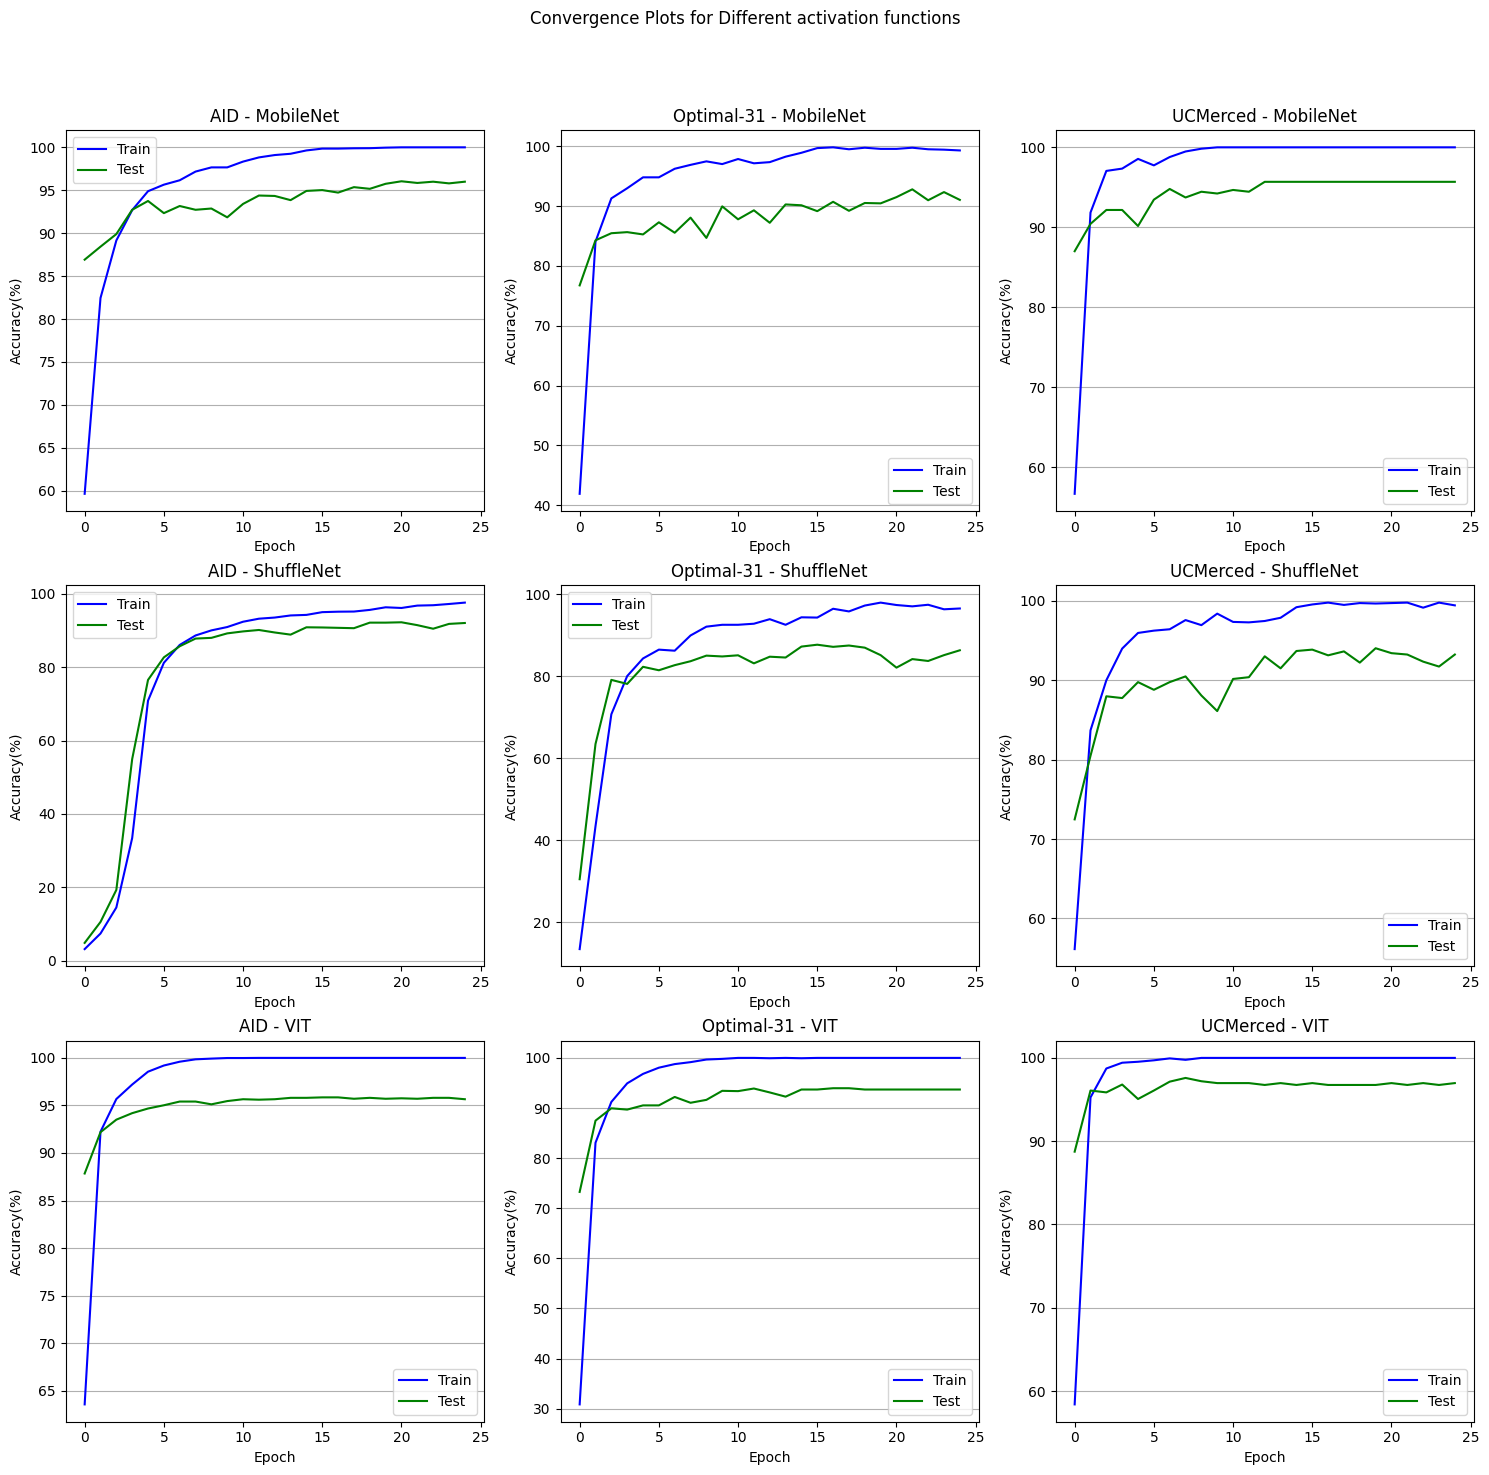

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

modelName = ['MobileNet', 'ShuffleNet', 'VIT']
datasetName = ['AID', 'Optimal-31', 'UCMerced']
modelsTrainAccs = [mobileNet_trainAccs, shuffleNet_trainAccs, VIT_trainAccs]
modelsTestAccs = [mobileNet_testAccs, shuffleNet_testAccs, VIT_testAccs]

for i in range(3):
    for j in range(3):
        axs[i,j].plot(modelsTrainAccs[i][j], label='Train', color='blue')
        axs[i,j].plot(modelsTestAccs[i][j], label='Test', color='green')
        axs[i,j].set_xlabel('Epoch')
        axs[i,j].set_ylabel('Accuracy(%)')
        axs[i,j].set_title(f'{datasetName[j]} - {modelName[i]}')
        axs[i,j].grid(axis='y')
        axs[i,j].autoscale(enable=True, axis='Accuracy(%)')
        axs[i,j].legend()

# Call tight_layout to automatically adjust the spacing between subplots
plt.tight_layout()

# Add a title to the entire figure
fig.suptitle('Convergence Plots for Different activation functions')

# Adjust the top margin to make more space for the suptitle
plt.subplots_adjust(top=0.9)

# Show the plot
plt.show()


In [13]:
from tabulate import tabulate

trainAccuracy_mat = []
testAccuracy_mat = []

for i in range(3):
    trainTemp = []
    testTemp = []
    for j in range(3):
        trainTemp.append(modelsTrainAccs[i][j][-1])
        testTemp.append(modelsTestAccs[i][j][-1])
    trainAccuracy_mat.append(trainTemp)
    testAccuracy_mat.append(testTemp)

# Define headers for columns and rows
headers = ['AID', 'Optimal-31', 'UCMerced']
row_headers = ['MobileNet', 'ShuffleNet', 'VIT']

table1 = tabulate(trainAccuracy_mat, headers=headers, showindex=row_headers, tablefmt="fancy_grid")
table2 = tabulate(testAccuracy_mat, headers=headers, showindex=row_headers, tablefmt="fancy_grid")

print("Training accuracies after 25 Epoches")
print(table1,'\n')
print("Test accuracies after 25 Epoches")
print(table2)

Training accuracies after 25 Epoches
╒════════════╤════════╤══════════════╤════════════╕
│            │    AID │   Optimal-31 │   UCMerced │
╞════════════╪════════╪══════════════╪════════════╡
│ MobileNet  │ 100    │      99.2839 │   100      │
├────────────┼────────┼──────────────┼────────────┤
│ ShuffleNet │  97.65 │      96.4844 │    99.4213 │
├────────────┼────────┼──────────────┼────────────┤
│ VIT        │ 100    │     100      │   100      │
╘════════════╧════════╧══════════════╧════════════╛ 

Test accuracies after 25 Epoches
╒════════════╤═════════╤══════════════╤════════════╕
│            │     AID │   Optimal-31 │   UCMerced │
╞════════════╪═════════╪══════════════╪════════════╡
│ MobileNet  │ 95.9961 │      91.0256 │    95.6845 │
├────────────┼─────────┼──────────────┼────────────┤
│ ShuffleNet │ 92.0898 │      86.2981 │    93.2292 │
├────────────┼─────────┼──────────────┼────────────┤
│ VIT        │ 95.6543 │      93.6899 │    96.9742 │
╘════════════╧═════════╧════════════